In [1]:
# import required libraries to manage data and visualize trends
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import bokeh as bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter

In [2]:
# import file for use of plotting trends and running models against
store3_path = Path('../data/store3_data.csv')
store3_data_visual = pd.read_csv(store3_path)
store3_data_visual = store3_data_visual.dropna(subset=['Sales', 'Gallons'])
store3_data_visual[['Sales', 'Gallons']] = store3_data_visual[['Sales', 'Gallons']].astype(int)
store3_data_visual['date'] = pd.to_datetime(store3_data_visual['date'])
store3_data_visual.set_index('date', inplace= True)
display(store3_data_visual.head())
display(store3_data_visual.tail())

,Sales,Gallons
date,,
2007-11-26,4697,148
2007-12-03,3233,88
2007-12-10,4526,133
2007-12-17,7291,250
2007-12-24,12813,313


,Sales,Gallons
date,,
2024-04-29,15687,256
2024-05-06,26200,492
2024-05-13,24729,473
2024-05-20,27596,571
2024-05-27,18877,281


In [3]:
store3_data_visual.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 989 entries, 2007-11-26 to 2024-05-27
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Sales    989 non-null    int32
 1   Gallons  989 non-null    int32
dtypes: int32(2)
memory usage: 15.5 KB


Boken Trend Visualization - to show how sales and gallons progrossed over time data exists
Can be useful in identifying trends or patterns where they may exist

In [15]:
# use of Bokeh library to plot our initial trend line for visual review
output_notebook()
# Create a ColumnDataSource from the DataFrame
source = ColumnDataSource(store3_data_visual)

# Create a figure
p = figure(x_axis_type='datetime', title='Store 3 Sales and Gallons Over Time', width = 1300, height = 500)
# p.line(x='date', y='Sales', source=source, line_width=2, legend_label='Sales', color='blue')
p.circle(x='date', y='Sales', source=source, size=8, color='blue', legend_label='Sales')
p.line(x='date', y='Gallons', source=source, line_width=2, legend_label='Gallons', color='green')
# p.circle(x='date', y='Gallons', source=source, size=8, color='green', legend_label='Gallons')

# Customize the plot
p.legend.location = 'top_left'
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Sales / Gallons'
p.yaxis.formatter = NumeralTickFormatter(format="0,0")
# p.grid.grid_line_alpha = 0.3

# Show the plot
show(p)

Loading BokehJS ...

In [16]:
# export image to be used in powerpoint
from bokeh.io import export_png
export_png(p, filename='../images/store3.png')

'c:\\group project 2\\project-2-group-3\\images\\store3.png'

Use of Lag Plot to reflect any identifiable correlation or patterns in the data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


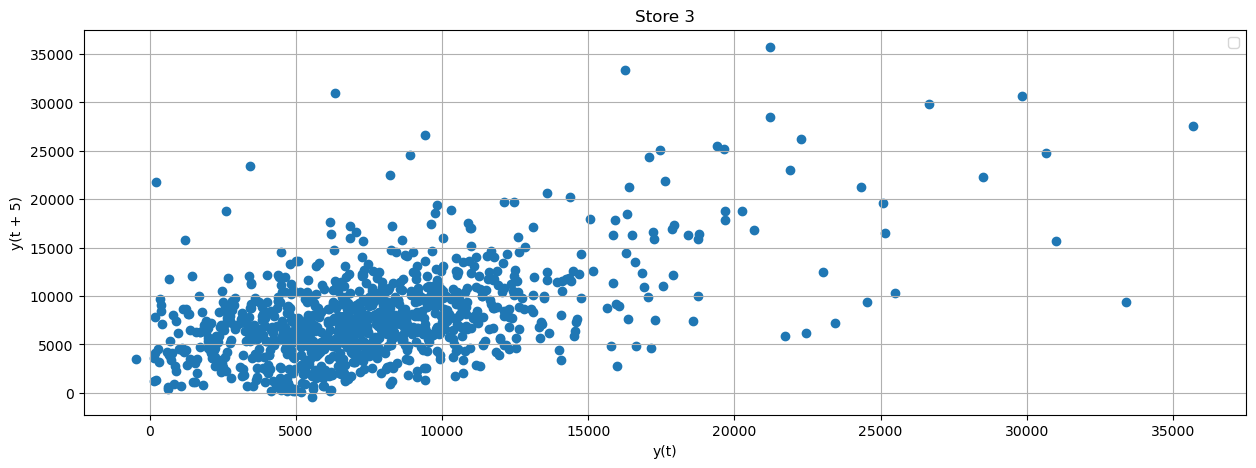

In [13]:
# Lag Plot to show patterns or any correlations
from pandas.plotting import lag_plot
fig = plt.figure(figsize=(15, 5))
lag_plot(store3_data_visual['Sales'], lag=5)
plt.title('Store 3')
plt.grid(True)
plt.legend();

Use of GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model to show volatility forecasts for our sales data

In [7]:
# import supporting library to run GARCH anaylsis
from arch import arch_model
from sklearn.preprocessing import StandardScaler

In [8]:
# build dataframe specific to run model on
store3_data_model = pd.read_csv(store3_path)
store3_data_model = store3_data_model.dropna(subset=['Sales', 'Gallons'])
store3_data_model[['Sales', 'Gallons']] = store3_data_model[['Sales', 'Gallons']].astype(int)
store3_data_model['date'] = pd.to_datetime(store3_data_model['date'])
store3_data_model.set_index('date', inplace= True)
display(store3_data_model.head())
display(store3_data_model.tail())

,Sales,Gallons
date,,
2007-11-26,4697,148
2007-12-03,3233,88
2007-12-10,4526,133
2007-12-17,7291,250
2007-12-24,12813,313


,Sales,Gallons
date,,
2024-04-29,15687,256
2024-05-06,26200,492
2024-05-13,24729,473
2024-05-20,27596,571
2024-05-27,18877,281


In [9]:
# scale sales data to better fit model
scaler = StandardScaler()
store3_data_model['Scaled'] = scaler.fit_transform(store3_data_model['Sales'].values.reshape(-1, 1))

In [10]:
# Fit GARCH(1,1) model
garch_model = arch_model(store3_data_model['Scaled'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1184.02
Distribution:                  Normal   AIC:                           2376.04
Method:            Maximum Likelihood   BIC:                           2395.63
                                        No. Observations:                  989
Date:                Mon, Jun 10 2024   Df Residuals:                      988
Time:                        11:15:49   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.2542  2.812e-02     -9.039  1.579e-19 [ -0.309, -0.19

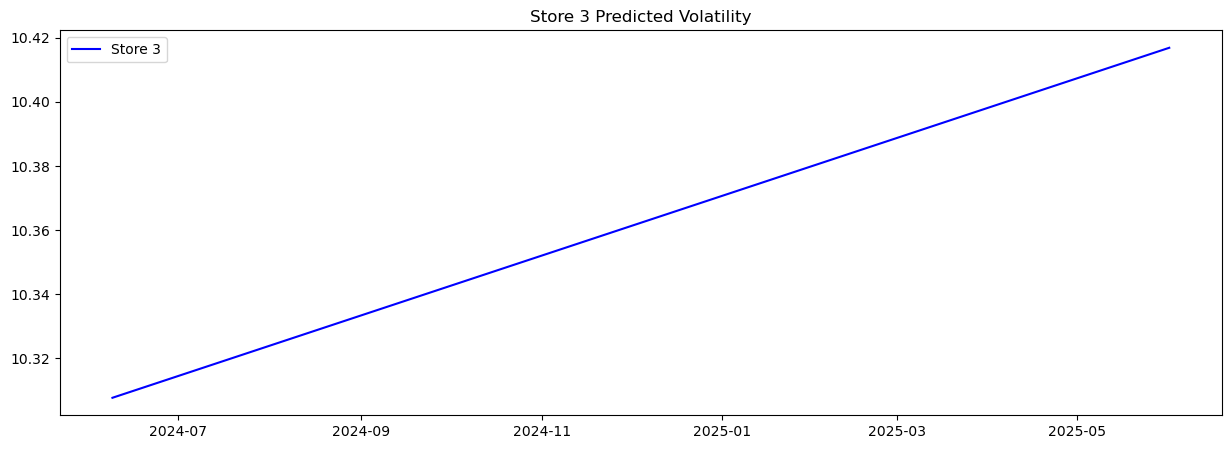

In [14]:
# Make volatility predictions
forecast_horizon = 52  # Predict the next 52 weeks
garch_forecast = garch_fit.forecast(horizon=forecast_horizon)

# Extract predicted volatility
predicted_volatility = garch_forecast.variance.values[-1, :]

# New DataFrame with furture predictions
last_date = store3_data_model.index[-1]
pred_dates = pd.date_range(start=last_date, periods=forecast_horizon+1, freq='W')[1:]
pred_df = pd.DataFrame(predicted_volatility, index=pred_dates, columns=['Predicted_Volatility'])

# Plot the predicted volatility
plt.figure(figsize=(15, 5))
plt.plot(pred_df, label='Store 3', color='blue')
plt.title('Store 3 Predicted Volatility')
plt.legend()
plt.show()